In [1]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Outliers detection
from sklearn.ensemble import IsolationForest

# Train/Test splitting
from sklearn.model_selection import train_test_split

# Lasso regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, normalize

# Neural networks
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

# Error
from sklearn.metrics import r2_score

In [2]:
#importing the data
X = pd.read_csv('X_train.csv', float_precision='high').drop('id', axis=1)
y = pd.read_csv('y_train.csv', float_precision='high').drop('id', axis=1)

# replacing the missing values with the median of that column
X = X.fillna(X.median())

# Isolation Forest

In [3]:
# creating the model
clf = IsolationForest(behaviour='new', max_samples=100, random_state = 1, contamination='auto')

# getting the outliers
preds = clf.fit_predict(X)

# removing outliers
X = X[preds==1]
y = y[preds==1]

# Splitting the dataset

In [4]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Choosing the most correlated features

No handles with labels found to put in legend.


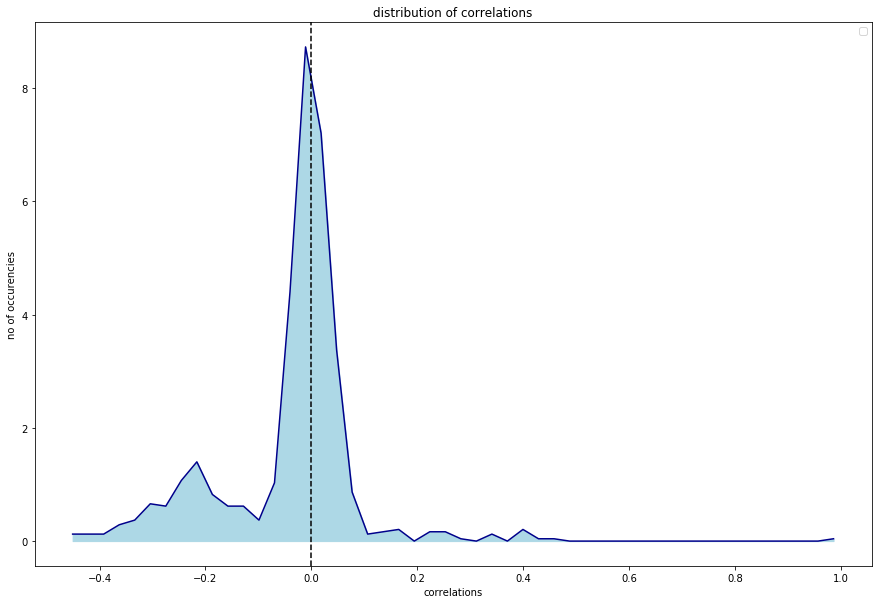

In [5]:
full_data = X_train.copy()
full_data['y'] = y_train

correlations = full_data.corr().y.dropna()

# plotting the distribution of feature importance
nbins = 50

n, bins = np.histogram(correlations.values, nbins, density=1)

pdfx, pdfy = np.zeros(n.size), np.zeros(n.size)

for k in range(n.size):
    pdfx[k], pdfy[k] = 0.5*(bins[k] + bins[k+1]), n[k]

plt.figure(figsize=(15,10))
plt.title('distribution of correlations')
plt.ylabel('no of occurencies')
plt.xlabel('correlations')

plt.plot(pdfx, pdfy, color = 'darkblue')
plt.fill_between(pdfx, pdfy, color = 'lightblue')

plt.axvline(x=0, color='k', linestyle='--')

plt.legend()
plt.show()

del full_data

In [102]:
# saving the correlated features
correlated_features_1 = correlations[((correlations > 0.1) | (correlations < -0.1)) & 
                                      (correlations.index != 'y')].index

correlated_features_2 = correlations[((correlations > 0.1) | (correlations < -0.15)) & 
                                      (correlations.index != 'y')].index

correlated_features_3 = correlations[((correlations > 0.15) | (correlations < -0.1)) & 
                                      (correlations.index != 'y')].index

correlated_features_4 = correlations[((correlations > 0.15) | (correlations < -0.15)) & 
                                      (correlations.index != 'y')].index

# Lasso regression

In [7]:
def apply_lasso_regression(degree, X_train_param, y_train_param, X_test_param):
    
    # creating regression model
    model = Lasso(alpha=0.0001, normalize=True)
    
    # Generates a new feature matrix consisting of all polynomial combinations of the features with degree 
    # less than or equal to the specified degree. For example, if an input sample is two dimensional and of 
    # the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].
    polynomial_features = PolynomialFeatures(degree)
    X_train_poly = polynomial_features.fit_transform(X_train_param)
    
    # fitting the train data
    model.fit(X_train_poly, y_train_param/100)
    
    # making predictions for test data
    X_test_poly = polynomial_features.fit_transform(X_test_param)
    y_pred = model.predict(X_test_poly)

    #calculating the accuracy
    score = r2_score(y_test, y_pred*100)
    
    print('The obtained r2 score is : ',score)
        
    return model

In [8]:
model = apply_lasso_regression(1, X_train, y_train, X_test)

The obtained r2 score is :  0.38485815808405066


In [14]:
lasso_features_1 = X.columns[(np.abs(model.coef_) > 1e-5)[1:]]
lasso_features_2 = X.columns[(np.abs(model.coef_) > 1e-6)[1:]]
lasso_features_3 = X.columns[(np.abs(model.coef_) > 1e-7)[1:]]
lasso_features_4 = X.columns[(np.abs(model.coef_) > 1e-8)[1:]]

# Neural network

In [20]:
# Splitting The Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

features_to_try = [correlated_features_1, correlated_features_2, correlated_features_3, correlated_features_4,
                   lasso_features_1, lasso_features_2, lasso_features_3, lasso_features_4]

scores = []

for features in features_to_try:
    # Normalizing the data

    # ----- Normalizing X values -----
    X_train_normalized = X_train[correlated_features_1]
    X_test_normalized = X_test[correlated_features_1]

    # Normalizing the X values
    X_train_normalized = (X_train_normalized - X_train_normalized.mean()) / X_train_normalized.std()
    X_test_normalized = (X_test_normalized - X_test_normalized.mean()) / X_test_normalized.std()

    # Making X numpy arrays
    X_train_normalized = X_train_normalized.values
    X_test_normalized = X_test_normalized.values

    # ----- Normalizing y values -----
    y_mean, y_std = y.mean()[0], y.std()[0]

    y_train_normalized = ((y_train - y_mean) / y_std).values
    
    # Fitting Neural Network
    
    n = X_train_normalized.shape[1]

    model = Sequential([Dense(n, activation='relu'),
                        Dense(1024, activation='relu'),
                        Dense(512, activation='relu'),
                        Dropout(0.1),
                        Dense(1024, activation='relu'),
                        Dense(1024, activation='relu'),
                        Dropout(0.1),
                        Dense(1024, activation='relu'),
                        Dropout(0.1),
                        Dense(512, activation='relu'),
                        Dense(256, activation='relu'),
                        Dense(1)])

    model.compile(loss='mean_absolute_error', optimizer='adam')
    model.fit(X_train_normalized, y_train_normalized, epochs=30)
    
    # Predicting values
    y_pred = model.predict(X_test_normalized)
    y_pred = y_pred*y_std + y_mean
    
    # Saving the score
    score = r2_score(y_test, y_pred)
    scores.append(score)

Epoch 1/30
965/965 [==============================] - 2s 2ms/sample - loss: 0.7107
Epoch 2/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.6074
Epoch 3/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.5253
Epoch 4/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.4625
Epoch 5/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.4673
Epoch 6/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.3810
Epoch 7/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.3533
Epoch 8/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.3491
Epoch 9/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.3365
Epoch 10/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.3084
Epoch 11/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.2928
Epoch 12/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.2768
E

Epoch 9/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.3457
Epoch 10/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.3155
Epoch 11/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.3266
Epoch 12/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.3025
Epoch 13/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.2851
Epoch 14/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.2514
Epoch 15/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.2431
Epoch 16/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.2631
Epoch 17/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.2489
Epoch 18/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.2529
Epoch 19/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.2283
Epoch 20/30
965/965 [==============================] - 1s 1ms/sample - loss: 

In [24]:
for i, score in enumerate(scores):
    print('The obtained r2 score when using {}-th features is: {}'.format(i,score))

The obtained r2 score when using 0-th features is: 0.4063514443141416
The obtained r2 score when using 1-th features is: 0.5254310618741506
The obtained r2 score when using 2-th features is: 0.45427620646740596
The obtained r2 score when using 3-th features is: 0.5224038176698866
The obtained r2 score when using 4-th features is: 0.47595019684449613
The obtained r2 score when using 5-th features is: 0.4369211056110065
The obtained r2 score when using 6-th features is: 0.4255409329691654
The obtained r2 score when using 7-th features is: 0.44484846466946415


In [103]:
# Splitting The Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalizing the data

# ----- Normalizing X values -----
X_train_normalized = X_train[correlated_features_1]
X_test_normalized = X_test[correlated_features_1]

# Normalizing the X values
X_train_normalized = (X_train_normalized - X_train_normalized.mean()) / X_train_normalized.std()
X_test_normalized = (X_test_normalized - X_test_normalized.mean()) / X_test_normalized.std()

# Making X numpy arrays
X_train_normalized = X_train_normalized.values
X_test_normalized = X_test_normalized.values

# ----- Normalizing y values -----
y_mean, y_std = y.mean()[0], y.std()[0]

y_train_normalized = ((y_train - y_mean) / y_std).values

# Fitting Neural Network

n = X_train_normalized.shape[1]

model = Sequential([Dense(n, activation='relu'),
                    Dense(1024, activation='relu'),
                    Dense(512, activation='relu'),
                    Dropout(0.1),
                    Dense(1024, activation='relu'),
                    Dense(1024, activation='relu'),
                    Dropout(0.1),
                    Dense(1024, activation='relu'),
                    Dropout(0.1),
                    Dense(512, activation='relu'),
                    Dense(256, activation='relu'),
                    Dense(1)])

model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(X_train_normalized, y_train_normalized, epochs=30)

Epoch 1/30
965/965 [==============================] - 4s 4ms/sample - loss: 0.7184
Epoch 2/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.6070
Epoch 3/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.5283
Epoch 4/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.4538
Epoch 5/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.4664
Epoch 6/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.4426
Epoch 7/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.3761
Epoch 8/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.3535
Epoch 9/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.3230
Epoch 10/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.3215
Epoch 11/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.2914
Epoch 12/30
965/965 [==============================] - 1s 1ms/sample - loss: 0.2885
E

# making final predictions

In [104]:
X_final = pd.read_csv('X_test.csv', float_precision='high')

In [105]:
ids = X_final.id

In [106]:
X_final.head()

,id,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x822,x823,x824,x825,x826,x827,x828,x829,x830,x831
0,0.0,116890.145646,4682.826460,102084.432558,988.163180,10412.331659,10.481227,103604.878991,1.095767e+06,100602.794631,...,11.027043,11.009213,1030.608247,1018.364228,108762.467652,105073.764746,7347.221554,8.598623,102506.589322,2.350805
1,1.0,104149.957877,3161.012055,93566.104799,1037.879907,11232.156777,10.143346,NaN,1.083111e+06,102331.038815,...,NaN,10.391822,1049.620654,972.516069,108773.164038,105822.141259,5687.349133,9.791258,107449.718830,2.278208
2,2.0,91332.402246,3922.735224,108810.999713,1008.536233,12030.362103,10.811671,107372.736023,1.075590e+06,104247.270565,...,10.648721,10.979466,973.772111,1068.819601,106851.090304,104651.998344,6510.915424,10.993281,107366.747806,2.171415
3,3.0,93281.714961,3707.283134,86947.473251,947.048927,10037.466655,10.208015,NaN,1.042872e+06,103283.424614,...,10.255209,10.566875,918.617516,NaN,104245.538474,102301.224747,NaN,9.845355,100865.094552,2.222927
4,4.0,88434.057156,5184.106152,85396.992336,1101.076469,10083.474388,10.124108,109507.125721,1.013667e+06,102676.240326,...,10.482693,10.784100,945.230640,1032.396697,106180.279333,104253.493703,6586.500123,11.953965,101665.694524,2.057716


In [107]:
X_final = X_final.fillna(X_final.median()).drop('id', axis=1)

X_final_normalized = X_final[correlated_features_1]

# Normalizing the X values
X_final_normalized = (X_final_normalized - X_final_normalized.mean()) / X_final_normalized.std()

# Making X numpy arrays
X_final_normalized = X_final_normalized.values

In [108]:
y_final_pred = model.predict(X_final_normalized)
y_final_pred = y_final_pred*y_std + y_mean
y_final_pred = y_final_pred.reshape(len(y_final_pred))

In [109]:
y_final_pred = pd.concat([ids,pd.Series(y_final_pred)], keys = ['id','y'], axis=1)

In [110]:
y_final_pred.head()

,id,y
0,0.0,68.277931
1,1.0,75.555748
2,2.0,85.321518
3,3.0,73.941383
4,4.0,80.665390


In [111]:
y_final_pred.to_csv('y_pred.csv')